# Cells per viral barcode
This notebook filters calculates and plots the number of cells each viral barcode appears in.

## Notebook setup
Import python modules:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import pandas as pd

import plotnine as p9

Get `snakemake` variables [as described here](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#jupyter-notebook-integration):

In [2]:
expt = 'scProgenyProduction_trial3'
viral_bc_background_freq_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_background_freq.csv.gz'
cells_per_viral_bc_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_cells_per_viral_bc.csv.gz'
plot = 'results/viral_fastq10x/scProgenyProduction_trial3_cells_per_viral_bc.pdf'
barcoded_viral_genes = ['fluHA', 'fluNA']

## Organize data
Read the viral barcode UMI counts data into a pandas dataframe:

In [3]:
viral_bc_frac = pd.read_csv(viral_bc_background_freq_csv)
assert set(viral_bc_frac['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."

display(viral_bc_frac)

,cell_barcode,infected,infecting_viral_tag,gene,viral_barcode,frac_viral_bc_UMIs,reject_uninfected,too_many_cells
0,AAACCCAGTAACAAGT,False,none,fluHA,NaN,0.000000,False,False
1,AAACCCATCATTGCTT,False,none,fluHA,NaN,0.000000,False,False
2,AAACGAAAGATGTTGA,False,none,fluHA,NaN,0.000000,False,False
3,AAACGAAGTACTTCCC,True,wt,fluHA,NaN,0.000000,False,False
4,AAACGAAGTAGACGTG,True,wt,fluHA,AAGTAAGCGACATGAG,0.001271,True,False
...,...,...,...,...,...,...,...,...
7706,TTTGATCTCCCGTTCA,False,none,fluNA,NaN,0.000000,False,False
7707,TTTGATCTCGCATTGA,True,wt,fluNA,NaN,0.000000,False,False
7708,TTTGGAGAGTTGCCTA,False,none,fluNA,NaN,0.000000,False,False
7709,TTTGGAGGTATCGTTG,True,wt,fluNA,ACATCTTATTTACACG,0.000349,False,False


Set base plot style:

In [4]:
p9.theme_set(p9.theme_classic())

## Cells per viral barcode
Next, I want to remove viral barcodes that are found above background in multiple cells. This should be very unlikely in a low MOI infection.

Calculate the number of cells each viral barcode is found in:

In [5]:
n_cell_bc = (viral_bc_frac
             .groupby(['infecting_viral_tag',
                       'gene',
                       'viral_barcode',
                       'reject_uninfected'])
             ['cell_barcode']
             .nunique()
             .reset_index()
             .rename(columns={'cell_barcode': 'n_cell_bc'}))

n_cell_bc

viral_bc_frac = pd.merge(
    viral_bc_frac,
    n_cell_bc,
    on=['infecting_viral_tag',
        'gene',
        'viral_barcode',
        'reject_uninfected'],
    how='left')

viral_bc_frac

,cell_barcode,infected,infecting_viral_tag,gene,viral_barcode,frac_viral_bc_UMIs,reject_uninfected,too_many_cells,n_cell_bc
0,AAACCCAGTAACAAGT,False,none,fluHA,NaN,0.000000,False,False,NaN
1,AAACCCATCATTGCTT,False,none,fluHA,NaN,0.000000,False,False,NaN
2,AAACGAAAGATGTTGA,False,none,fluHA,NaN,0.000000,False,False,NaN
3,AAACGAAGTACTTCCC,True,wt,fluHA,NaN,0.000000,False,False,NaN
4,AAACGAAGTAGACGTG,True,wt,fluHA,AAGTAAGCGACATGAG,0.001271,True,False,1.0
...,...,...,...,...,...,...,...,...,...
7706,TTTGATCTCCCGTTCA,False,none,fluNA,NaN,0.000000,False,False,NaN
7707,TTTGATCTCGCATTGA,True,wt,fluNA,NaN,0.000000,False,False,NaN
7708,TTTGGAGAGTTGCCTA,False,none,fluNA,NaN,0.000000,False,False,NaN
7709,TTTGGAGGTATCGTTG,True,wt,fluNA,ACATCTTATTTACACG,0.000349,False,False,1.0


Plot distribution of cell barcode per viral barcode:

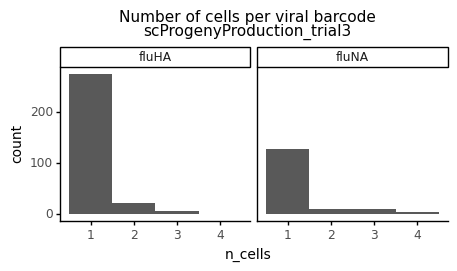

<ggplot: (8782889214970)>

In [6]:
fig = (p9.ggplot(viral_bc_frac
                 .query('reject_uninfected == True')) +
       p9.geom_histogram(p9.aes(x='n_cell_bc'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of cells per viral barcode\n'
                  f'{expt}') +
       p9.xlab('n_cells') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

### Annotate viral barcodes that are found in more than 1 cell.
Now I will label viral barcodes that are found in more than 1 cells.

In [7]:
viral_bc_frac['gt1_cell'] = (viral_bc_frac['n_cell_bc'] > 1)

viral_bc_frac

,cell_barcode,infected,infecting_viral_tag,gene,viral_barcode,frac_viral_bc_UMIs,reject_uninfected,too_many_cells,n_cell_bc,gt1_cell
0,AAACCCAGTAACAAGT,False,none,fluHA,NaN,0.000000,False,False,NaN,False
1,AAACCCATCATTGCTT,False,none,fluHA,NaN,0.000000,False,False,NaN,False
2,AAACGAAAGATGTTGA,False,none,fluHA,NaN,0.000000,False,False,NaN,False
3,AAACGAAGTACTTCCC,True,wt,fluHA,NaN,0.000000,False,False,NaN,False
4,AAACGAAGTAGACGTG,True,wt,fluHA,AAGTAAGCGACATGAG,0.001271,True,False,1.0,False
...,...,...,...,...,...,...,...,...,...,...
7706,TTTGATCTCCCGTTCA,False,none,fluNA,NaN,0.000000,False,False,NaN,False
7707,TTTGATCTCGCATTGA,True,wt,fluNA,NaN,0.000000,False,False,NaN,False
7708,TTTGGAGAGTTGCCTA,False,none,fluNA,NaN,0.000000,False,False,NaN,False
7709,TTTGGAGGTATCGTTG,True,wt,fluNA,ACATCTTATTTACACG,0.000349,False,False,1.0,False


Plot number of viral barcodes that were found in too many cells:

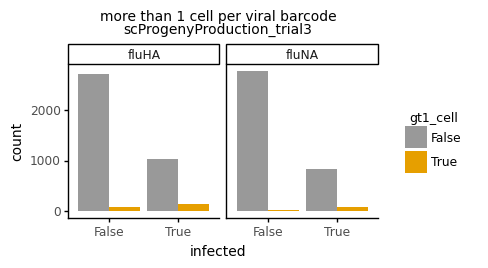

<ggplot: (8782884977954)>

In [8]:
output_fig = (p9.ggplot(viral_bc_frac,
                        p9.aes(x='infected',
                               fill='gt1_cell')) +
              p9.geom_bar(stat='count', position='dodge') +
              p9.ggtitle('more than 1 cell per viral barcode\n'
                         f'{expt}') +
              p9.facet_grid('~gene') +
              p9.theme(figure_size=(4, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(output_fig)

Export plot:

In [9]:
print(f"Saving plots to {plot}")
p9.ggsave(plot=output_fig, filename=plot, verbose=False)

Saving plots to results/viral_fastq10x/scProgenyProduction_trial3_cells_per_viral_bc.pdf


Export CSV:

In [10]:
# Export all viral barcodes with new annotation.
viral_bc_frac.to_csv(cells_per_viral_bc_csv,
                     columns=['cell_barcode',
                              'infected',
                              'infecting_viral_tag',
                              'gene',
                              'viral_barcode',
                              'frac_viral_bc_UMIs',
                              'reject_uninfected',
                              'gt1_cell'],
                     index=False)